In [145]:
import os
import json
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class View(object):
    
    def __init__(self, df):
        self.df = df
        
    def select(self, key, lst):
        self.df = self.df[(self.df.index.get_level_values(key).isin(lst))]
        
    def run(self, steps):
        for s in steps:
            self.select(list(s.keys())[0], list(s.values())[0])
    
    def latex(self):
        print(self.df.to_latex(float_format="%.2f"))

In [102]:
path = '../sentence_similarity/results/'

records = []
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if name.endswith('.json') and name.startswith('result_'):
            with open(os.path.join(root, name), 'r') as f:
                lst = json.load(f)
                records.extend(lst)

In [103]:
for item in records:
    
    if item['lang'] == 'ptbr':
        item['dataset'] = 'ASSIN ( pt-BR )'
    elif item['lang'] == 'pteu':
        item['dataset'] = 'ASSIN ( pt-PT )'
    elif item['lang'] == 'assin2':
        item['dataset'] = 'ASSIN 2'
        
    if 'cbow' in item['test']:
        item['architecture'] = 'CBOW'
    elif 'skip' in item['test']:
        item['architecture'] = 'skip-gram'
    else:
        item['architecture'] = ' '

    if 'embeddings' in item['test']:
        item['embedding'] = item['test'].split('/')[-2]
        item['dimensions'] = int(re.findall('\d+', item['test'].split('/')[-1])[0])
    else:
        item['embedding'] = ' '
        item['dimensions'] = ' '
        
    if 'ELMo' in item['test']:
        if 'custom1' in item['test']:
            item['ELMo'] = 'wiki (reduced)'
        elif 'custom2' in item['test']:
            item['ELMo'] = 'BRWAC'
        else:
            item['ELMo'] = 'wiki'
    else:
        item['ELMo'] = ' '
        
    if 'unk' in item['test']:
        item['unk'] = True
    else:
        item['unk'] = False

In [4]:
df = pd.DataFrame(records).round(2)
df = df[['dataset', 'ELMo', 'embedding', 'unk', 'architecture', 'dimensions', 'pearson', 'MSE']]\
.rename(columns={'pearson': 'PCC'})
df = df.groupby(['dataset', 'ELMo', 'embedding', 'unk', 'architecture', 'dimensions']).apply(np.mean)
df = df[['PCC', 'MSE']]
df.to_csv('../reports/evaluation.csv')

Text(0.5, 1.05, 'Effect of Out-of-Vocabulary word replacement strategies on a Semantic Textual Similarity task : ASSIN 1 ( pt-BR )')

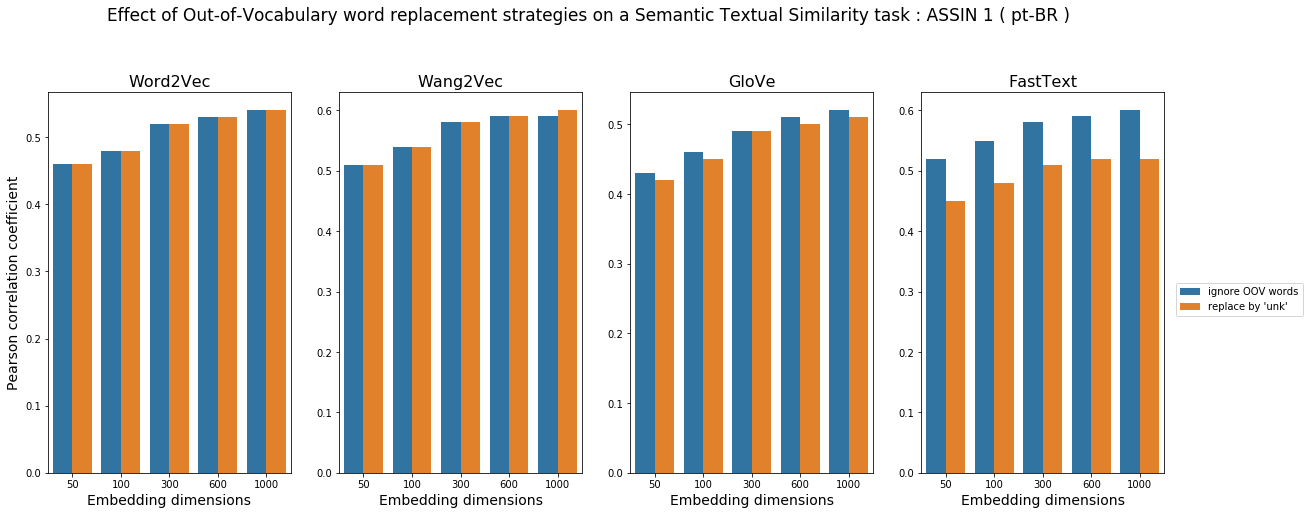

In [106]:
EMBEDDINGS = ['word2vec', 'wang2vec', 'glove', 'fasttext']
PRETTY_EMBEDDINGS = ['Word2Vec', 'Wang2Vec', 'GloVe', 'FastText']

def embedding_plot_generator(df):
    for item in EMBEDDINGS:
        view = View(df)
        steps = [
            {
                "embedding" : [item]
            },
            {
                "architecture": ['skip-gram', ' ', '']
            },
            {
                "dataset": ['ASSIN ( pt-BR )']
            },
            {
                "ELMo": ['', ' ']
            }
        ]
        view.run(steps)
        plot_df = view.df.reset_index()
        yield plot_df

plt.rcParams['figure.figsize'] = [20,7]
fig, axs = plt.subplots(ncols=4)    

plot_df = []
plots = []
for item in embedding_plot_generator(df):
    item['unk'] = item['unk'].astype(str).str.replace('False', "ignore OOV words")
    item['unk'] = item['unk'].astype(str).str.replace('True', "replace by 'unk'")
    plot_df.append(item)
    
for idx, item in enumerate(plot_df):
    plots.append(sns.barplot(x='dimensions', y='PCC', hue='unk', data=plot_df[idx], ax=axs[idx]))

for idx, item in enumerate(plots):
    g = plots[idx]
    if idx != len(plots) - 1:
        g.get_legend().remove()
    else:
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
    g.axes.set_ylabel(" ")
    g.axes.set_xlabel("Embedding dimensions", fontsize=14)
    g.axes.set_title(PRETTY_EMBEDDINGS[idx], fontsize=16)
    
plots[0].set_ylabel("Pearson correlation coefficient", fontsize=14)

fig.suptitle('Effect of Out-of-Vocabulary word replacement strategies on a Semantic Textual Similarity task : ASSIN 1 ( pt-BR )',\
             fontsize=17, y=1.05)

In [150]:
view = View(df)

steps = [
    {
        "ELMo" : ['wiki', 'wiki (reduced)']
    },
    {
        "embedding": [' ', '']
    }
]

view.run(steps)
view.df
view.df = view.df.reset_index()[['dataset', 'ELMo', 'PCC', 'MSE']].groupby(['dataset', 'ELMo']).mean()
view.df

PCC   MSE
dataset         ELMo                      
ASSIN ( pt-BR ) wiki            0.61  0.48
                wiki (reduced)  0.62  0.47
ASSIN ( pt-PT ) wiki            0.62  0.75
                wiki (reduced)  0.63  0.74
ASSIN 2         wiki            0.55  0.80
                wiki (reduced)  0.57  0.77

In [147]:
view.latex()

\begin{tabular}{llrr}
\toprule
        &                &  PCC &  MSE \\
dataset & ELMo &      &      \\
\midrule
ASSIN ( pt-BR ) & wiki & 0.61 & 0.48 \\
        & wiki (reduced) & 0.62 & 0.47 \\
ASSIN ( pt-PT ) & wiki & 0.62 & 0.75 \\
        & wiki (reduced) & 0.63 & 0.74 \\
ASSIN 2 & wiki & 0.55 & 0.80 \\
        & wiki (reduced) & 0.57 & 0.77 \\
\bottomrule
\end{tabular}



In [162]:
view = View(df)

steps = [
    {
        "ELMo" : ['wiki', 'wiki (reduced)', '', ' ']
    },
    {
        "embedding": ['fasttext', 'glove', 'word2vec', ' ', '']
    },
    {
        "dataset": ["ASSIN ( pt-BR )"]
    },
    {
        'unk': [False, 'False', '', ' ']
    },
    {
        "dimensions": [1000, '', ' ']
    }
]

view.run(steps)
view.df

PCC  \
dataset         ELMo           embedding unk   architecture dimensions         
ASSIN ( pt-BR )                fasttext  False CBOW         1000        0.40   
                                               skip-gram    1000        0.60   
                               glove     False              1000        0.52   
                               word2vec  False CBOW         1000        0.58   
                                               skip-gram    1000        0.54   
                wiki                     False                          0.61   
                               fasttext  False CBOW         1000        0.41   
                                               skip-gram    1000        0.64   
                               glove     False              1000        0.58   
                               word2vec  False CBOW         1000        0.63   
                                               skip-gram    1000        0.62   
                wiki (reduced)           False                          0.62   
                               fasttext  False CBOW         1000        0.42   
                                               skip-gram    1000        0.64   
                               glove     False              1000        0.60   
                               word2vec  False CBOW         1000        0.63   
                                               skip-gram    1000        0.63   

                                                                         MSE  
dataset         ELMo           embedding unk   architecture dimensions        
ASSIN ( pt-BR )                fasttext  False CBOW         1000        0.64  
                                               skip-gram    1000        0.49  
                               glove     False              1000        0.56  
                               word2vec  False CBOW         1000        0.50  
                                               skip-gram    1000        0.54  
                wiki                     False                          0.48  
                               fasttext  False CBOW         1000        0.63  
                                               skip-gram    1000        0.45  
                               glove     False              1000        0.50  
                               word2vec  False CBOW         1000        0.46  
                                               skip-gram    1000        0.47  
                wiki (reduced)           False                          0.47  
                               fasttext  False CBOW         1000        0.63  
                                               skip-gram    1000        0.45  
                               glove     False              1000        0.49  
                               word2vec  False CBOW         1000        0.45  
                                               skip-gram    1000        0.46